Task 3 a)

In [1]:
def weighted_degree_kernel(s1,s2,d,betas):
    """ weighted degree kernel function
    s1(String): sequence 1 
    s2(String): sequence 2 
    d (Int): length of k-mers
    betas (float): coefficients
    return K(float): kernel value
    """
    K= 0
    for k in range (1,d+1):
        I= 0
        beta = betas[k-1]
        for l in range (0,(len(s1)-k+1)):
            if (s1[l:l+k]==s2[l:l+k]):
                I = I+1
        K= K+ (beta * I)          
    return K

In [2]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Task 3 b)

In [3]:
sequences=[]
for seq_record in SeqIO.parse(r'sequencesMSAfasta.sec','fasta'):
    sequences.append(str(seq_record.seq))
#generate possible sequence combinations
s = list(range(0,len(sequences)))
combis= list(itertools.combinations_with_replacement(s, 2))
#init kernel_matrix
kernel_matrix=np.zeros((len(sequences),len(sequences)))
d= 3
betas = np.array([2*(d-k+1)/(d*(d+1)) for k in range(1,d+1)])
#fill kernel matrix
for i in range (len(combis)):
    s1= sequences[combis[i][0]]
    s2= sequences[combis[i][1]]
    kernel_matrix[combis[i][0]][combis[i][1]]= weighted_degree_kernel(s1,s2,d,betas)
    kernel_matrix[combis[i][1]][combis[i][0]]= kernel_matrix[combis[i][0]][combis[i][1]]

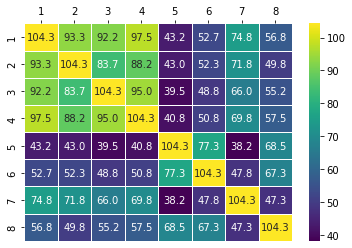

In [4]:
kernel_matrix= pd.DataFrame(kernel_matrix,columns=[1,2,3,4,5,6,7,8])
kernel_matrix.index= [1,2,3,4,5,6,7,8]
ax = sns.heatmap(kernel_matrix, cmap='viridis',annot=True,fmt=".1f",linewidth=.5)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.savefig('kernel_matrix.png', dpi=600)

Task 4 a)

In [5]:
def dirac(a1, a2):
    """ dirac kernel function
    a1(String): allele 1 
    a2(String): allele 1 
    return K(float): kernel value
    """
    K = 0
    if a1 == a2:
        K = 1            
    return K

def uniform(a1, a2):
    """ uniform kernel function
    a1(String): allele 1 
    a2(String): allele 1 
    return K(float): kernel value
    """
    return 1

def multitask(a1, a2):
    """ multistask kernel function combination of dirac & uniform kernel function
    a1(String): allele 1 
    a2(String): allele 1 
    return K(float): kernel value 
    """
    K = dirac(a1, a2) + uniform(a1, a2)
    return K

def peptide(p1,p2):
    """ peptide kernel function
    p1(String):peptide sequence 1, 
    p2(String):peptide sequence 2, 
    return K(float): kernel value 
    """
    K= 0
    for l in range (len(p1)):
        if (p1[l]==p2[l]):
                K = K+1  
    
    return K

Task 4 b)

In [6]:
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
from itertools import combinations

In [7]:
binding_data= pd.read_csv('BindingData.csv', delimiter=',')
binding_data_Y= binding_data[' binding label']

In [14]:
def kernel_combination (allele_kernel, peptide_kernel,a1,a2,p1,p2):
    """ Function to combine different kernels 
    allele_kernel: kernel function used for the allele kernel
    peptide_kernel:kernel function used for the peptide kernel
    a1(String): allele 1 
    a2(String): allele 1
    p1(String):peptide sequence 1, 
    p2(String):peptide sequence 2, 
    return K(float): kernel value"""
    a = allele_kernel(a1,a2)
    p = peptide_kernel(p1,p2)
    K = a*p
    return K

In [15]:
# used a function from Stackoverflow to perform parameter tuning and 10-fold cross validation at the same time, by only calculating the kernelmatrix ones
#link: https://stackoverflow.com/questions/24595874/nested-cross-validation-in-grid-search-for-precomputed-kernels-in-scikit-learn


def precomputed_kernel_GridSearchCV(K, y, Cs, n_splits=10, test_size=0.2, random_state=42):
    """A version of grid search CV, 
    but adapted for SVM with a precomputed kernel
    K (np.ndarray) : precomputed kernel
    y (np.array) : labels
    Cs (iterable) : list of values of C to try
    return: optimal value of C and best score 
    """
    n = K.shape[0]
    assert len(K.shape) == 2
    assert K.shape[1] == n
    assert len(y) == n
    
    best_score = float('-inf')
    best_C = None
 
    indices = np.arange(n)
    
    for C in Cs:
        # for each value of parameter, do K-fold
        # The performance measure reported by k-fold cross-validation 
        # is the average of the values computed in the loop
        scores = []
        ss = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
        for train_index, test_index in ss.split(indices):
            K_train = K[np.ix_(train_index,train_index)]
            K_test = K[np.ix_(test_index, train_index)]
            y_train = y[train_index]
            y_test = y[test_index]
            svc = SVC(kernel='precomputed', C=C)
            svc.fit(K_train, y_train)
            scores.append(svc.score(K_test, y_test))
        if np.mean(scores) > best_score:
            best_score = np.mean(scores)
            best_C = C
    return best_C,best_score

In [16]:
def predefined_kernel_matrix (allele_kernel,peptide_kernel,data):
    K_comb= np.zeros((len(data),len(data)))
    indexes = data.index.values.tolist()
    combinations= list(itertools.combinations_with_replacement(indexes, 2))
    for i in range (len(combinations)):
        K_comb[combinations[i][0]][combinations[i][1]]= kernel_combination(allele_kernel,peptide_kernel,data[' allele'][combinations[i][0]], data[' allele'][combinations[i][1]],data[' peptide sequence'][combinations[i][0]], data[' peptide sequence'][combinations[i][1]])
        K_comb[combinations[i][1]][combinations[i][0]]= K_comb[combinations[i][0]][combinations[i][1]]
    
    return K_comb

In [17]:
C=[10**(-4),10**(-3),10**(-2),10**(-1), 10**0, 10**1, 10**2]
dirac_best_C,dirac_best_score= precomputed_kernel_GridSearchCV(predefined_kernel_matrix(dirac,peptide,binding_data),binding_data_Y, C)

In [18]:
uniform_best_C,uniform_best_score= precomputed_kernel_GridSearchCV(predefined_kernel_matrix(uniform,peptide,binding_data),binding_data_Y, C)

In [19]:
multitask_best_C,multitask_best_score= precomputed_kernel_GridSearchCV(predefined_kernel_matrix(multitask,peptide,binding_data),binding_data_Y, C)

Task 4 c)

In [20]:
supertype= pd.read_csv('supertype.csv', delimiter=',')
binding_data_supertype= binding_data.copy()

In [21]:
supertype['Genotypes'] = supertype.Genotypes.str.split(',')
supertype= supertype.explode('Genotypes')
supertype.reset_index(inplace = True)
supertype.loc[:, 'Genotypes'] = 'HLA-' + supertype.loc[:, 'Genotypes'].str.replace(' ', '')
for i in range(len(supertype['Genotypes'])):
    supertype['Genotypes'][i]=(supertype['Genotypes'][i][:8]+ ':'+supertype['Genotypes'][i][8:])
    
for x in supertype['Genotypes']:
    for y in binding_data_supertype[' allele']:
        if (x==y):
            binding_data_supertype[' allele']= supertype['Supertype']

C:\Users\marid\AppData\Local\Temp/ipykernel_20716/3673415444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertype['Genotypes'][i]=(supertype['Genotypes'][i][:8]+ ':'+supertype['Genotypes'][i][8:])


In [22]:
supertype_multitask_best_C,supertype_multitask_best_score= precomputed_kernel_GridSearchCV(predefined_kernel_matrix(multitask,peptide,binding_data_supertype),binding_data_Y, C)

In [23]:
data = {'kernel functions':  ['dirac x peptide', 'uniform x peptide', 'multitask x peptide', 'supertype_multitask x peptide'],
        'best C': [dirac_best_C, uniform_best_C,multitask_best_C, supertype_multitask_best_C],
        'best score':[dirac_best_score,uniform_best_score,multitask_best_score,supertype_multitask_best_score]
        }

results = pd.DataFrame(data)
results

,kernel functions,best C,best score
0,dirac x peptide,0.1,0.622308
1,uniform x peptide,0.1,0.618846
2,multitask x peptide,0.1,0.618846
3,supertype_multitask x peptide,0.1,0.622692


Task d) 

In [82]:
from sklearn.metrics import roc_curve, auc

aucs = dict()

y = binding_data_Y
C = dirac_best_C
n = K.shape[0]


    

In [123]:
def roc_curve_and_auc(K, data, C, title,  n_splits=10):
    y = data
    C = C
    n = K.shape[0]
    aucs = []
    indices = np.arange(n)
    ss = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    for train_index, test_index in ss.split(indices):
        K_train = K[np.ix_(train_index,train_index)]
        K_test = K[np.ix_(test_index, train_index)]
        y_train = y[train_index]
        y_test = y[test_index]
        svc = SVC(kernel='precomputed', C=C, probability=True)
        svc.fit(K_train, y_train)
        y_pred = svc.predict_proba(K_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
        aucs.append(auc(fpr, tpr))
    plt.title("ROC curve"+ title)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.plot(fpr, tpr) 
    auc_val = np.mean(np.array(aucs))
    print("AUC is: ", auc_val)
    return auc_val

AUC is:  0.6669323461347642


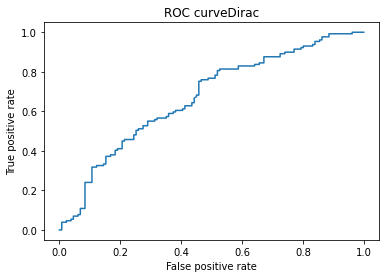

In [124]:
K_dirac = predefined_kernel_matrix(dirac,peptide,binding_data)
auc_dirac = roc_curve_and_auc(K, binding_data_Y, dirac_best_C, "Dirac")
aucs["dirac"]= auc_dirac


AUC is:  0.647075133999423


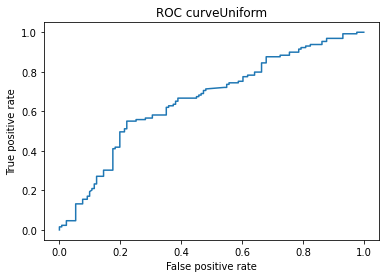

In [125]:
K_uniform = predefined_kernel_matrix(uniform,peptide,binding_data)
auc_uniform = roc_curve_and_auc(K_uniform, binding_data_Y, uniform_best_C, "Uniform")
aucs["uniform"]= auc_uniform


AUC is:  0.6732917997616348


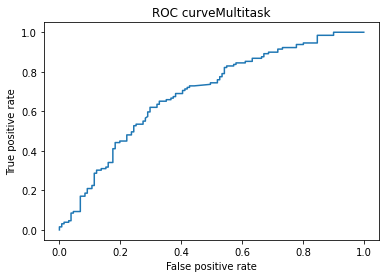

In [126]:
K_multitask = predefined_kernel_matrix(multitask,peptide,binding_data)
auc_multitask = roc_curve_and_auc(K_multitask, binding_data_Y, uniform_best_C, "Multitask")
aucs["multitask "]= auc_multitask

AUC is:  0.6612050662741396


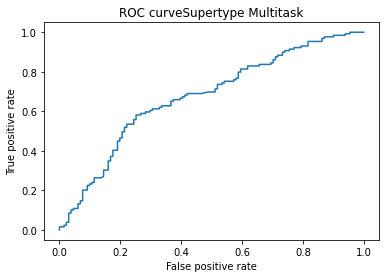

In [127]:
K_supertype_multitask = predefined_kernel_matrix(multitask,peptide,binding_data_supertype)
auc_supertype_multitask = roc_curve_and_auc(K_supertype_multitask, binding_data_Y, uniform_best_C, "Supertype Multitask")
aucs["supertype_multitask"]= auc_supertype_multitask

Task e) 

In [128]:
auc_data = {'kernel functions':  ['dirac x peptide', 'uniform x peptide', 'multitask x peptide', 'supertype_multitask x peptide'],
        'best C': [dirac_best_C, uniform_best_C,multitask_best_C, supertype_multitask_best_C],
        'best score':[dirac_best_score,uniform_best_score,multitask_best_score,supertype_multitask_best_score],
        'AUC': [auc_dirac, auc_uniform, auc_multitask, auc_supertype_multitask]
        }

auc_results = pd.DataFrame(auc_data)
auc_results

,kernel functions,best C,best score,AUC
0,dirac x peptide,0.1,0.622308,0.666932
1,uniform x peptide,0.1,0.618846,0.647075
2,multitask x peptide,0.1,0.618846,0.673292
3,supertype_multitask x peptide,0.1,0.622692,0.661205
